<a href="https://colab.research.google.com/github/shreetishresthanp/medical_summaries_evaluation/blob/main/summaries_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Set up Environment and Install Dependencies

In [1]:
# Verify GPU setup
! nvidia-smi

Fri Apr 25 16:46:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Transformers installation
! pip install transformers[torch] datasets evaluate rouge_score
# Install dependencies
! pip install torch
! pip install bert_score
! pip install textstat

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00


In [3]:
# optional huggingface authentication using token
from huggingface_hub import notebook_login

notebook_login()

#### Load dataset

In [5]:
from datasets import load_dataset

# load test_data.csv
med_dataset = load_dataset("csv", data_files="test_data.csv", split = "train")
med_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['abstract_text', 'target_text'],
    num_rows: 150
})

In [7]:
# example of a record in the dataset
med_dataset[0]

{'abstract_text': 'In 2015, Zika virus (ZIKV; Flaviviridae; Flavivirus) emerged in the Americas, causing millions of infections in dozens of countries. The rapid spread of the virus and the association with disease outcomes such as Guillain-Barre syndrome and microcephaly make understanding transmission dynamics essential. Currently, there are no reports of vector competence (VC) of American mosquitoes for ZIKV isolates from the Americas. Further, it is not clear whether ZIKV strains from other genetic lineages can be transmitted by American Aedes aegypti populations, and whether the scope of the current epidemic is in part facilitated by viral factors such as enhanced replicative fitness or increased vector competence. Therefore, we characterized replication of three ZIKV strains, one from each of the three phylogenetic clades in several cell lines and assessed their abilities to be transmitted by Ae. aegypti mosquitoes. Additionally, laboratory colonies of different Culex spp. were i

#### Generate Summaries

In [8]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu" # checks if gpu is available
pipeline_device = 0 if device == "cuda" else -1 # for determining if we want to load model in GPU or CPU

In [9]:
model_id = "Falconsai/medical_summarization"
prompt = "Generate a plain language summary that is easy to read highlighting key points and removing unnecessary details that can be easily understood by non-medical people : "

In [10]:
from transformers import AutoTokenizer, AutoModel
model = AutoModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [11]:
from transformers import pipeline

# Process inputs in batches to avoid running out of memory in Colab when testing larger models
batch_size = 16 # Adjust this value based on available memory
summarized_outputs = []
summarizer = pipeline("summarization", model=model_id, tokenizer=tokenizer, device=pipeline_device)

for i in range(0, len(med_dataset["abstract_text"]), batch_size):
    inputs_batch = [prompt + doc for doc in med_dataset["abstract_text"][i:i + batch_size]]
    outputs_batch = summarizer(inputs_batch, min_length=20, max_length=150, do_sample=False)
    summarized_outputs.extend([output["summary_text"] for output in outputs_batch])

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0
Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


#### Write outputs to file

In [12]:
import csv
with open("summarized_outputs.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["abstract_text", "target_text", "generated_text"])
    for i in range(len(summarized_outputs)):
      writer.writerow([med_dataset["abstract_text"][i], med_dataset["target_text"][i], summarized_outputs[i]])

### Evaluation

In [13]:
import evaluate
import textstat

In [14]:
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

#### ROUGE Score

In [15]:
agg_rouge_scores = rouge.compute(predictions=summarized_outputs, references=med_dataset["target_text"], use_stemmer=True, use_aggregator=True)
agg_rouge_scores

{'rouge1': np.float64(0.3802241064006395),
 'rouge2': np.float64(0.12239030452211948),
 'rougeL': np.float64(0.20637352215998378),
 'rougeLsum': np.float64(0.20625828366919094)}

In [16]:
from statistics import mean
print("Average of Rouge Scores (ROUGE-1, ROUGE-2, and ROUGE-L): ", mean([agg_rouge_scores['rouge1'], agg_rouge_scores['rouge2'], agg_rouge_scores['rougeL']]))

Average of Rouge Scores (ROUGE-1, ROUGE-2, and ROUGE-L):  0.23632931102758092


In [17]:
import pandas as pd

rouge_scores = rouge.compute(predictions=summarized_outputs, references=med_dataset["target_text"], use_stemmer=True, use_aggregator=False)
metric_df = pd.DataFrame(rouge_scores)
metric_df.drop(columns=["rougeLsum"], inplace=True)
metric_df["avg_rouge_score"] = metric_df.mean(axis=1)
metric_df.head()


,rouge1,rouge2,rougeL,avg_rouge_score
0,0.436019,0.133971,0.246445,0.272145
1,0.444444,0.142857,0.222222,0.269841
2,0.464455,0.229665,0.265403,0.319841
3,0.396476,0.071111,0.167401,0.211663
4,0.304965,0.085714,0.170213,0.186964


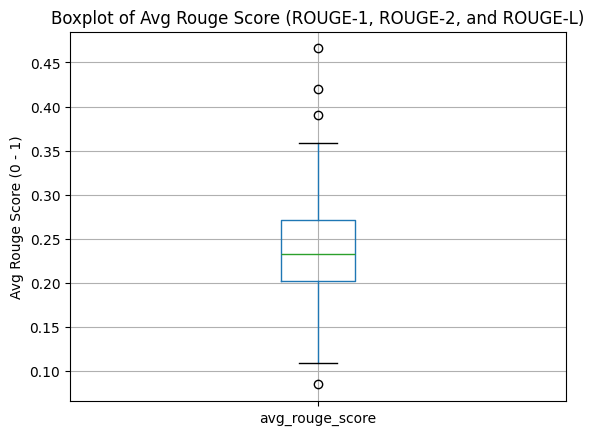

In [18]:
# Box plot for avg rouge scores of all records
import matplotlib.pyplot as plt
metric_df.boxplot(column='avg_rouge_score')
plt.title('Boxplot of Avg Rouge Score (ROUGE-1, ROUGE-2, and ROUGE-L)')
plt.ylabel('Avg Rouge Score (0 - 1)')
plt.show()

<Axes: ylabel='avg_rouge_score'>

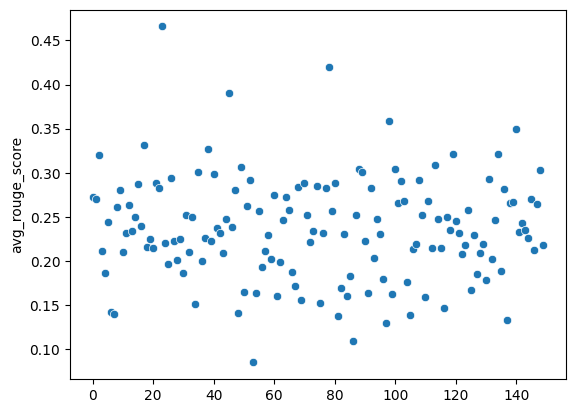

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=metric_df, y="avg_rouge_score", x = range(len(metric_df)))

#### BLEU Score

In [20]:
bleu_score = bleu.compute(predictions=summarized_outputs, references=med_dataset["target_text"])
bleu_score

{'bleu': 0.0474928710031669,
 'precisions': [0.5133763204829195,
  0.1558774604934849,
  0.07017789606387449,
  0.03977916194790487],
 'brevity_penalty': 0.3884719289056136,
 'length_ratio': 0.513997602425781,
 'translation_length': 14578,
 'reference_length': 28362}

In [21]:
print(f"BLEU Score: {bleu_score['bleu'] * 100:.2f}")

BLEU Score: 4.75


#### BERT Score

In [22]:
bert_score = bertscore.compute(predictions=summarized_outputs, references=med_dataset["target_text"], lang="en")
bert_score

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.861781120300293,
  0.884640097618103,
  0.8865375518798828,
  0.8490968942642212,
  0.8407275080680847,
  0.8468427062034607,
  0.8308360576629639,
  0.8387956023216248,
  0.8676413297653198,
  0.8699310421943665,
  0.8748437166213989,
  0.8361721038818359,
  0.8635470271110535,
  0.8539218902587891,
  0.8365383148193359,
  0.8706270456314087,
  0.8784723281860352,
  0.8751646876335144,
  0.8513727188110352,
  0.8359113335609436,
  0.8451143503189087,
  0.8908746838569641,
  0.8535295724868774,
  0.9053739905357361,
  0.8903168439865112,
  0.8359177112579346,
  0.8554432392120361,
  0.8607141971588135,
  0.8505169153213501,
  0.8598591089248657,
  0.8152740597724915,
  0.8840727806091309,
  0.8490583896636963,
  0.8778908848762512,
  0.8343428373336792,
  0.8683516979217529,
  0.8477516174316406,
  0.8544948101043701,
  0.872917890548706,
  0.8557006120681763,
  0.8885632157325745,
  0.8538485765457153,
  0.834571897983551,
  0.8373720645904541,
  0.8377627730369568,
 

In [23]:
bert_metric_df = pd.DataFrame(bert_score)
bert_metric_df.drop(columns=["hashcode"], inplace=True)
bert_metric_df["precision"] = (bert_metric_df["precision"]*100).round(2)
bert_metric_df["recall"] = (bert_metric_df["recall"]*100).round(2)
bert_metric_df["f1"] = (bert_metric_df["f1"]*100).round(2)
bert_metric_df.head()

,precision,recall,f1
0,86.18,87.33,86.75
1,88.46,86.17,87.30
2,88.65,86.73,87.68
3,84.91,85.97,85.44
4,84.07,84.15,84.11


In [24]:
precision_mean = bert_metric_df['precision'].mean()
recall_mean = bert_metric_df['recall'].mean()
f1_mean = bert_metric_df['f1'].mean()
print(f"Precision Mean: {precision_mean:.2f}")
print(f"Recall Mean: {recall_mean:.2f}")
print(f"F1 Mean: {f1_mean:.2f}")

Precision Mean: 85.72
Recall Mean: 85.05
F1 Mean: 85.37


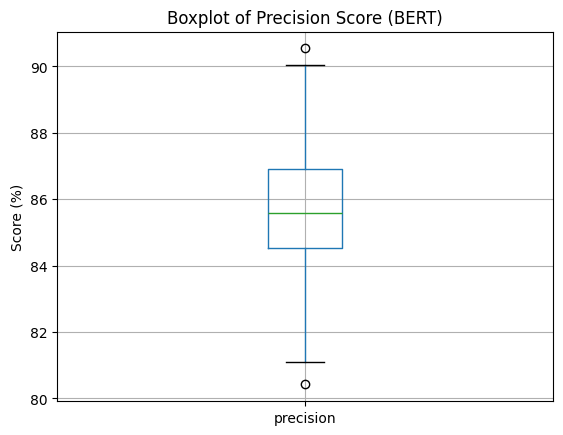

In [25]:
# Box plot for precision scores of all records
bert_metric_df.boxplot(column='precision')
plt.title('Boxplot of Precision Score (BERT)')
plt.ylabel('Score (%)')
plt.show()

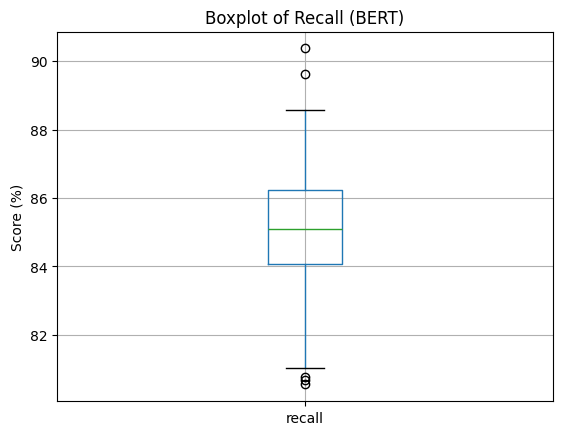

In [26]:
# Box plot for precision scores of all records
bert_metric_df.boxplot(column='recall')
plt.title('Boxplot of Recall (BERT)')
plt.ylabel('Score (%)')
plt.show()

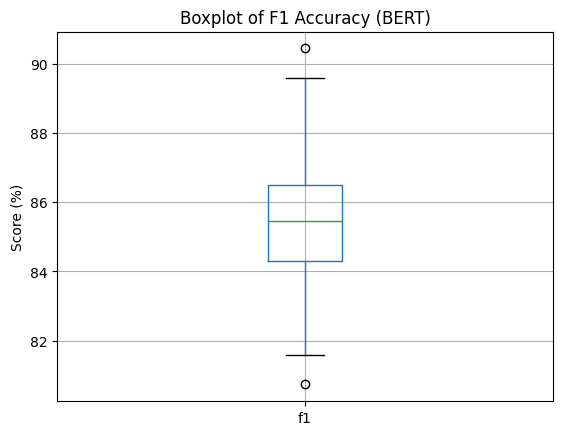

In [27]:
# Box plot for precision scores of all records
bert_metric_df.boxplot(column='f1')
plt.title('Boxplot of F1 Accuracy (BERT)')
plt.ylabel('Score (%)')
plt.show()

In [28]:
del bert_score['hashcode']

<ipython-input-29-08ff92a2bc81>:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(bert_score.values(), labels=bert_score.keys())


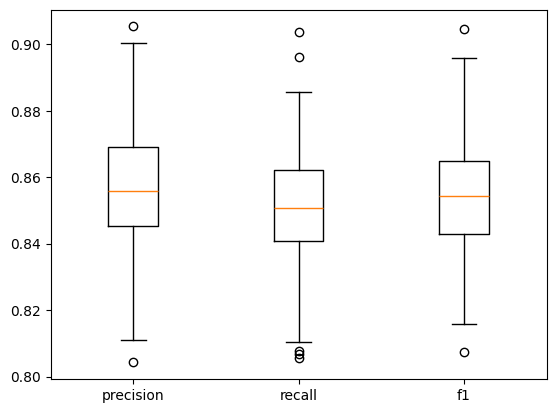

In [29]:
plt.boxplot(bert_score.values(), labels=bert_score.keys())
plt.show()

####  Flesch-Kincaid Grade Level (Readability Metric)

In [30]:
flesch_kincaid_grades = [textstat.flesch_kincaid_grade(summary) for summary in summarized_outputs]
flesch_reading_ease = [textstat.flesch_reading_ease(summary) for summary in summarized_outputs]

readability_scores = {
    "flesch_kincaid_grade": flesch_kincaid_grades,
    "flesch_reading_ease": flesch_reading_ease
}
# flesch_kincaid_grades[:5]
# flesch_reading_ease[:5]

In [31]:
from statistics import mean
print("Average of Flesch-Kincaid Grade Level (FKGL): ", mean(flesch_kincaid_grades))
print("Average of Flesch Reading Ease (FRE): ", mean(flesch_reading_ease))

Average of Flesch-Kincaid Grade Level (FKGL):  16.511333333333333
Average of Flesch Reading Ease (FRE):  16.161266666666666


<ipython-input-32-ce6324aee3ec>:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(readability_scores.values(), labels=readability_scores.keys())


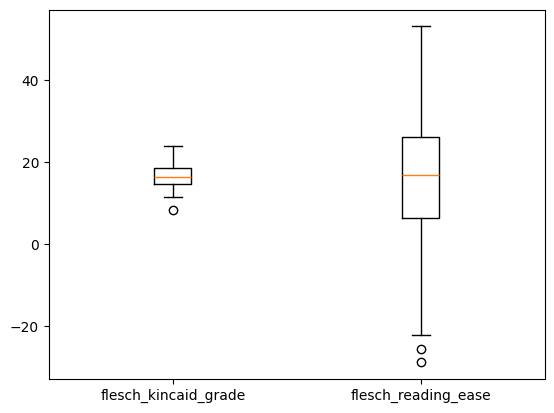

In [32]:
plt.boxplot(readability_scores.values(), labels=readability_scores.keys())
plt.show()

#### Human Evaluation Metrics

In [33]:
q_1 = [2,2,3,3,3,4,1,1,2,2,3,4,2,3,3,2,3,4,2,3,3,2,3,4,4,4,4,3,3,3]
q_2 = [1,2,3,3,3,3,1,1,2,1,2,3,1,2,2,1,3,3,1,3,4,1,3,3,3,4,4,2,3,3]
q_3 = [2,2,2,1,2,3,2,2,3,2,2,3,2,2,3,2,2,3,2,2,3,1,2,4,3,3,3,2,3,3]
q_4 = [1,2,3,3,3,4,1,1,2,1,3,3,1,2,2,2,3,4,1,2,2,2,2,3,2,3,3,2,3,3]
q_5 = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,2]

In [34]:
d = {'q1': q_1, 'q2': q_2, 'q3': q_3, 'q4': q_4, 'q5': q_5}
df = pd.DataFrame(data=d)
df.head()

,q1,q2,q3,q4,q5
0,2,1,2,1,1
1,2,2,2,2,1
2,3,3,2,3,1
3,3,3,1,3,1
4,3,3,2,3,1


<ipython-input-35-c9852393096c>:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df.values, labels=df.keys())


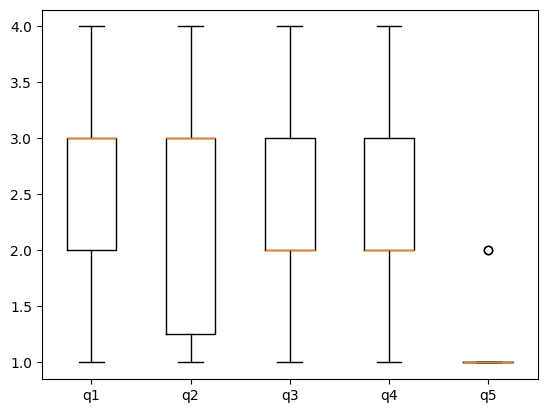

In [35]:
plt.boxplot(df.values, labels=df.keys())
plt.show()

In [36]:
mean_q1 = df['q1'].mean()
mean_q2 = df['q2'].mean()
mean_q3 = df['q3'].mean()
mean_q4 = df['q4'].mean()
mean_q5 = df['q5'].mean()
print("Average of Question 1: ", mean_q1)
print("Average of Question 2: ", mean_q2)
print("Average of Question 3: ", mean_q3)
print("Average of Question 4: ", mean_q4)
print("Average of Question 5: ", mean_q5)

Average of Question 1:  2.8333333333333335
Average of Question 2:  2.3666666666666667
Average of Question 3:  2.3666666666666667
Average of Question 4:  2.3
Average of Question 5:  1.0666666666666667


In [37]:
std_1 = df['q1'].std()
std_2 = df['q2'].std()
std_3 = df['q3'].std()
std_4 = df['q4'].std()
std_5 = df['q5'].std()
print("Standard Deviation of Question 1: ", std_1)
print("Standard Deviation of Question 2: ", std_2)
print("Standard Deviation of Question 3: ", std_3)
print("Standard Deviation of Question 4: ", std_4)
print("Standard Deviation of Question 5: ", std_5)

Standard Deviation of Question 1:  0.8742813140471174
Standard Deviation of Question 2:  0.9994251221140299
Standard Deviation of Question 3:  0.6686751354593717
Standard Deviation of Question 4:  0.876906789368961
Standard Deviation of Question 5:  0.2537081317024624


In [40]:
from statistics import median
median_q1 = df['q1'].median()
median_q2 = df['q2'].median()
median_q3 = df['q3'].median()
median_q4 = df['q4'].median()
median_q5 = df['q5'].median()
print("Median of Question 1: ", median_q1)
print("Median of Question 2: ", median_q2)
print("Median of Question 3: ", median_q3)
print("Median of Question 4: ", median_q4)
print("Median of Question 5: ", median_q5)

Median of Question 1:  3.0
Median of Question 2:  3.0
Median of Question 3:  2.0
Median of Question 4:  2.0
Median of Question 5:  1.0


In [41]:
from scipy import stats
iqr_q1 = stats.iqr(df['q1'])
iqr_q2 = stats.iqr(df['q2'])
iqr_q3 = stats.iqr(df['q3'])
iqr_q4 = stats.iqr(df['q4'])
iqr_q5 = stats.iqr(df['q5'])
print("IQR of Question 1: ", iqr_q1)
print("IQR of Question 2: ", iqr_q2)
print("IQR of Question 3: ", iqr_q3)
print("IQR of Question 4: ", iqr_q4)
print("IQR of Question 5: ", iqr_q5)

IQR of Question 1:  1.0
IQR of Question 2:  1.75
IQR of Question 3:  1.0
IQR of Question 4:  1.0
IQR of Question 5:  0.0
